In [2]:
# General
import os
import sys
import shutil
import posixpath
import warnings
import importlib
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# SciPy
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from scipy.signal import periodogram, butter, filtfilt

# Gpflow & tensorflow
import tensorflow as tf
from tensorflow_probability import distributions as tfd
import gpflow
f64 = gpflow.utilities.to_default_float
from gpflow.kernels import *

# Files
import csv
import pandas as pd
import seaborn as sns
import wfdb
from scipy.io import loadmat  

# Local scripts
#sys.path.insert(0, '/home/david/Documenten/Courses/Spectral Discontinuity Design/Thesis AI/Implementation/')
sys.path.insert(0, os.chdir(".."))
from SpectralMixture import SpectralMixture, initialize_from_emp_spec
import toolbox as t
from bnqdflow import models, base, effect_size_measures, util, analyses
sns.set(style='whitegrid')

ModuleNotFoundError: No module named 'wfdb'

### Load in data

In [2]:
with open('datasets/post-ictal-heart-rate-oscillations-in-partial-epilepsy-1.0.0/times.seize', 'r') as file:
    seizure_times = file.read()
    print(seizure_times)
    
fs          = 200
nyquist     = fs/2
start_time  = [0, 14, 36] # hours, minutes, seconds
end_time    = [0, 16, 12] # hours, minutes, seconds
duration    = 5 # seconds
n           = duration*fs 
b           = int(n/2)

sz01 00:14:36 00:16:12
sz02 01:02:43 01:03:43
sz02 02:55:51 02:56:16
sz03 01:24:34 01:26:22
sz03 02:34:27 02:36:17
sz04 00:20:10 00:21:55
sz05 00:24:07 00:25:30
sz06 00:51:25 00:52:19
sz06 02:04:45 02:06:10
sz07 01:08:02 01:09:31



In [3]:
# Read in recording 
start_index = start_time[0]*60*60*fs + start_time[1]*60*fs + start_time[2]*fs
end_index   = end_time[0]*60*60*fs + end_time[1]*60*fs + end_time[2]*fs
# Additional shift to ensure that the data aligns well at the intervention
end_index += 157

record_control     = wfdb.rdrecord('datasets/post-ictal-heart-rate-oscillations-in-partial-epilepsy-1.0.0/sz01',sampfrom=start_index-b, sampto=start_index)
data_control       = record_control.p_signal.flatten()

record_intervention= wfdb.rdrecord('datasets/post-ictal-heart-rate-oscillations-in-partial-epilepsy-1.0.0/sz01',sampfrom=end_index, sampto=end_index+b)
data_intervention  = record_intervention.p_signal.flatten()

print(start_index, end_index-15,end_index, b)
data = np.append(data_control, data_intervention)

print('Control data: ', data_control.shape)
print('Intervention data: ', data_intervention.shape)
print('Continuous data: ', data.shape)


175200 194542 194557 500
Control data:  (500,)
Intervention data:  (500,)
Continuous data:  (1000,)


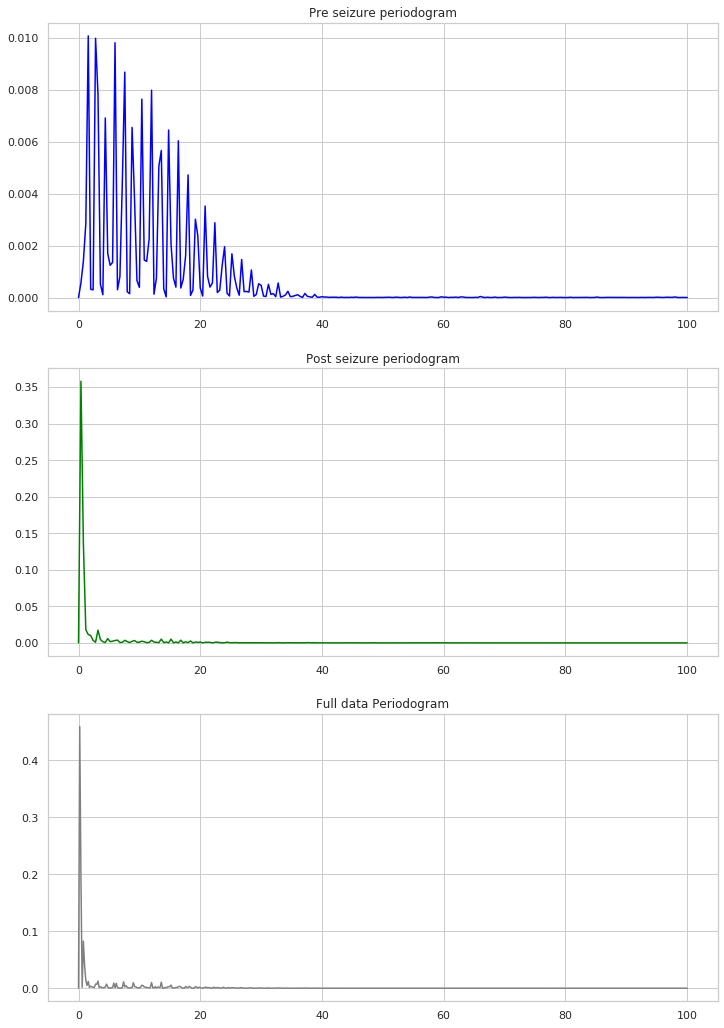

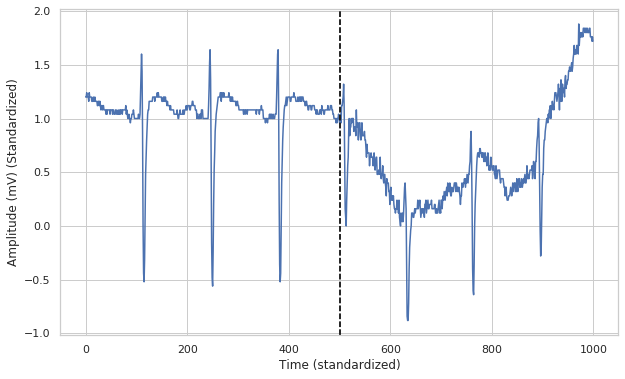

In [4]:
# plot unprocessed data
n_plots = 3
fig, ax = plt.subplots(n_plots,1, figsize=(12,6*n_plots))

# Plot periodogram
freqs, Pxx = periodogram(x=data[:b], fs=fs)
ax[0].plot(freqs, Pxx, color='blue')
ax[0].set_title('Pre seizure periodogram')

freqs, Pxx = periodogram(x=data[b:], fs=fs)
ax[1].plot(freqs, Pxx, color='green')
ax[1].set_title('Post seizure periodogram')

freqs, Pxx = periodogram(x=data, fs=fs)
ax[2].plot(freqs, Pxx,color='grey')
ax[2].set_title('Full data Periodogram')
plt.show()

# Plot signal
fig = plt.figure(figsize=(10, 6))
plt.plot(np.arange(data.shape[0]), data)
plt.axvline(b,color='k', linestyle='--')
plt.axvline(b,color='k', linestyle='--')

#plt.xticks(np.arange(0,1200, 125),np.arange(0,5,0.5))
#plt.yticks([-0.5,-1,-1.5])
plt.ylabel('Amplitude (mV) (Standardized)')
plt.xlabel('Time (standardized)')
plt.savefig('postictalData.pdf', dpi=250)
plt.show()

In [5]:
def smoothTriangle(data, degree):
    triangle=np.concatenate((np.arange(degree + 1), np.arange(degree)[::-1])) # up then down
    smoothed=[]

    for i in range(degree, len(data) - degree * 2):
        point=data[i:i + len(triangle)] * triangle
        smoothed.append(np.sum(point)/np.sum(triangle))
    # Handle boundaries
    smoothed=[smoothed[0]]*int(degree + degree/2) + smoothed
    while len(smoothed) < len(data):
        smoothed.append(smoothed[-1])
    return smoothed


triangular_smoothing = True

if triangular_smoothing:
    degree = 2
    Y = np.array(smoothTriangle(data, degree))
    
    ### Downsample to 100Hz
    fs = fs/degree
    nyquist = fs/degree
    print('fs: ', round(fs,2), 'nyquist: ', round(nyquist,2))
    
    Y = Y[np.arange(int(n))%degree==0]
    n = int(n/degree)
    b = int(b/degree)
    

fs:  100.0 nyquist:  50.0


In [6]:
# Standardize data
zscorey = lambda x: (x - np.mean(Y)) / np.std(Y)
zscorex = lambda x: (x - np.mean(X)) / np.std(X)
X = np.arange(Y.shape[0])
b = zscorex(b)
X = zscorex(X)
Y = zscorey(Y)


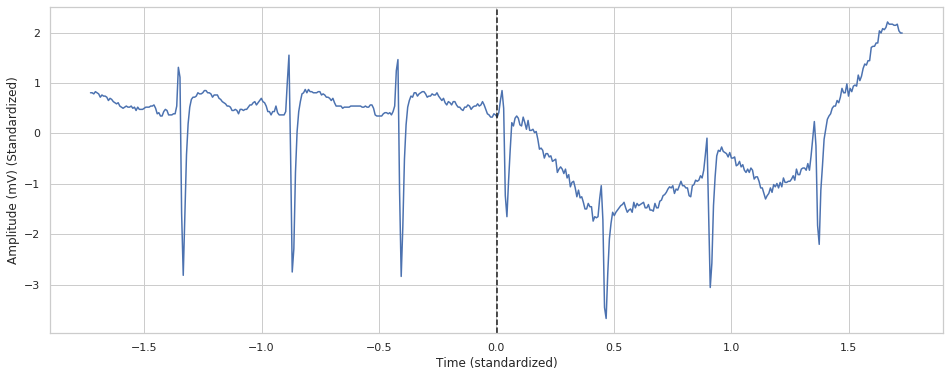

In [7]:
# Plot signal
from matplotlib.ticker import LinearLocator, FormatStrFormatter

fig, ax = plt.subplots(1,1,figsize=(16,6))
plt.plot(X,Y)
plt.axvline(b,color='k', linestyle='--')
#plt.xticks(np.arange(0,1200, 125),np.arange(0,5,0.5))
#plt.yticks([-0.5,-1,-1.5])
plt.ylabel('Amplitude (mV) (Standardized)')
plt.xlabel('Time (standardized)')
plt.show()

### Spectral Discontinuity Analysis

In [8]:
# Data used by the control model and intervention model
x1, x2      = X[X < b,], X[X>=b,]
y1, y2      = Y[X < b,], Y[X>=b,]

# Plotting parameters
padding           = 0.

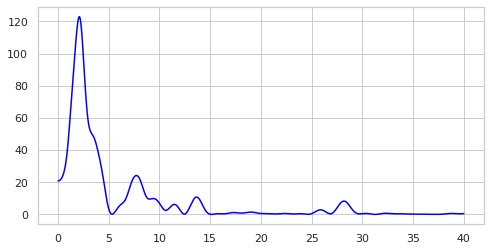

frequencies: [27.74402723  3.09492535 11.46763293  1.57650748 35.75679763  7.38103269
 19.00256689 13.96608337  9.29556649  4.3971987   0.47305655  2.09553297
 30.04281155 23.06109139  6.32107357 25.87652905 13.41998388  2.54140759
  1.12010085 38.19441539 28.47213411  3.77069455  8.13647672 33.17223562
 10.23259503]
lengthscales: [3.97231025e+00 4.50612862e+00 3.09814032e+00 5.38137804e+00
 1.00000000e+03 3.09138706e+00 9.26032403e-01 2.37531696e+00
 2.57216301e+00 3.37735359e+00 4.12607917e+00 5.41257972e+00
 1.95807963e+00 1.01842090e+00 2.82908010e+00 2.25650971e+00
 2.61345116e+00 5.24313066e+00 5.48828171e+00 1.51547907e+00
 2.87776337e+00 4.14950223e+00 3.19770036e+00 1.24252261e+00
 2.83360026e+00]
weights: [0.00813394 0.10642953 0.0147644  0.13667238 0.00099997 0.05304951
 0.00807314 0.01783895 0.02533794 0.06079313 0.04929322 0.15935224
 0.00425179 0.00451146 0.01910856 0.00942607 0.02358434 0.11124475
 0.05767942 0.003      0.01759657 0.06253286 0.03157747 0.00400776
 0.0107

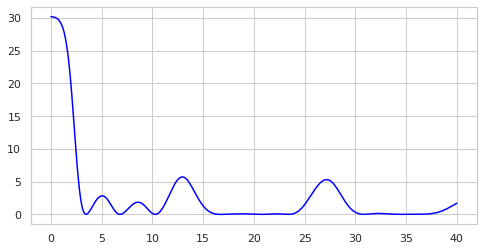

frequencies: [ 0.24056725 27.22740439 13.25607683 39.17506726  2.4711028   8.58309368
  1.04073267  4.97388478 33.17244206 10.91540277 25.96132468 28.74108365
 15.77496877  1.50476453 14.7047873   0.62398102 12.59919269  4.21393275
 25.13376625 27.91820141  2.03493708  6.03552439 11.78351176 13.95096543
 26.64906127]
lengthscales: [6.87833469 3.50584454 3.50212667 1.58754201 3.07927568 1.71488181
 5.27168484 3.88188206 1.01497729 7.19625722 4.13160543 1.79345784
 2.79618843 4.99729359 4.37494026 6.2580304  3.63374026 4.30149613
 1.03350921 3.02747465 4.22599482 3.65645647 4.38450609 3.88673358
 4.30983746]
weights: [0.09458804 0.03278351 0.03569075 0.0159998  0.05974388 0.02401088
 0.11381843 0.02620775 0.004021   0.00339097 0.01785688 0.02743228
 0.00419882 0.11996439 0.01403619 0.13500579 0.03314068 0.01390622
 0.01394711 0.03881707 0.09288248 0.01087553 0.0145399  0.02699931
 0.02614236]


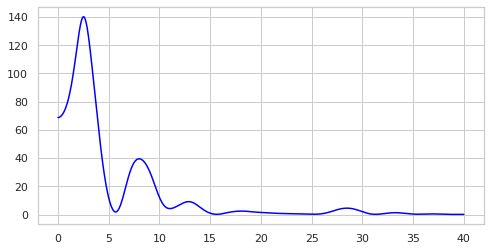

frequencies: [ 2.32114924 20.86241182  8.72975256 27.82867343 13.57700503  0.39968259
  4.54074846 32.36264687  7.38539504 17.76410934  3.17070906 29.61202365
  1.12645939 11.9077331   9.18002761  6.41013144  3.81359568 34.60378845
 22.74404628 19.73496554  1.77967822  2.76005889  9.88401594 33.42348736
  8.04593462]
lengthscales: [5.78828229 2.56241964 5.04151484 1.65990221 1.62060431 4.09467902
 2.73343096 4.95470063 3.12867143 1.47693515 5.03761671 1.75364073
 4.19840694 2.40295807 5.89897619 2.15120342 3.79993127 4.40368698
 1.98416624 6.07404537 4.43521395 5.58389421 3.40634452 8.40398035
 3.66840824]
weights: [0.13199145 0.00427015 0.02936356 0.01260535 0.02878204 0.09244439
 0.03253593 0.00300001 0.03710862 0.00605985 0.07975949 0.00739473
 0.08580911 0.01722083 0.03113651 0.02168028 0.09830138 0.00200001
 0.00485021 0.00382765 0.09788717 0.09395258 0.02635896 0.0029999
 0.04865984]
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
╒════════════════════════════════════════════════════════════════╤═══════════╤════════════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════════════╕
│ name                                                           │ class     │ transform              │ prior   │ trainable   │ shape   │ dtype   │            value │
╞════════════════════════════════════════════════════════════════╪═══════════╪════════════════════════╪═════════╪═════════════╪═════════╪═════════╪══════════════════╡
│ DiscontinuousModel.models[0].kernel.kernels[0].mixture_weight  │ Parameter │ Sigmoid + AffineScalar │         │ True        │ ()      │ float64 │      0.000195608 │
├────────────────────────────

L: 46.46126515590436, k: 154, N: 500
BIC: -432.0635584226044
L: -1.4260095371993202, k: 77, N: 500
BIC: -240.6884213264537
Bayes factor Md-Mc: -191.3751370961507


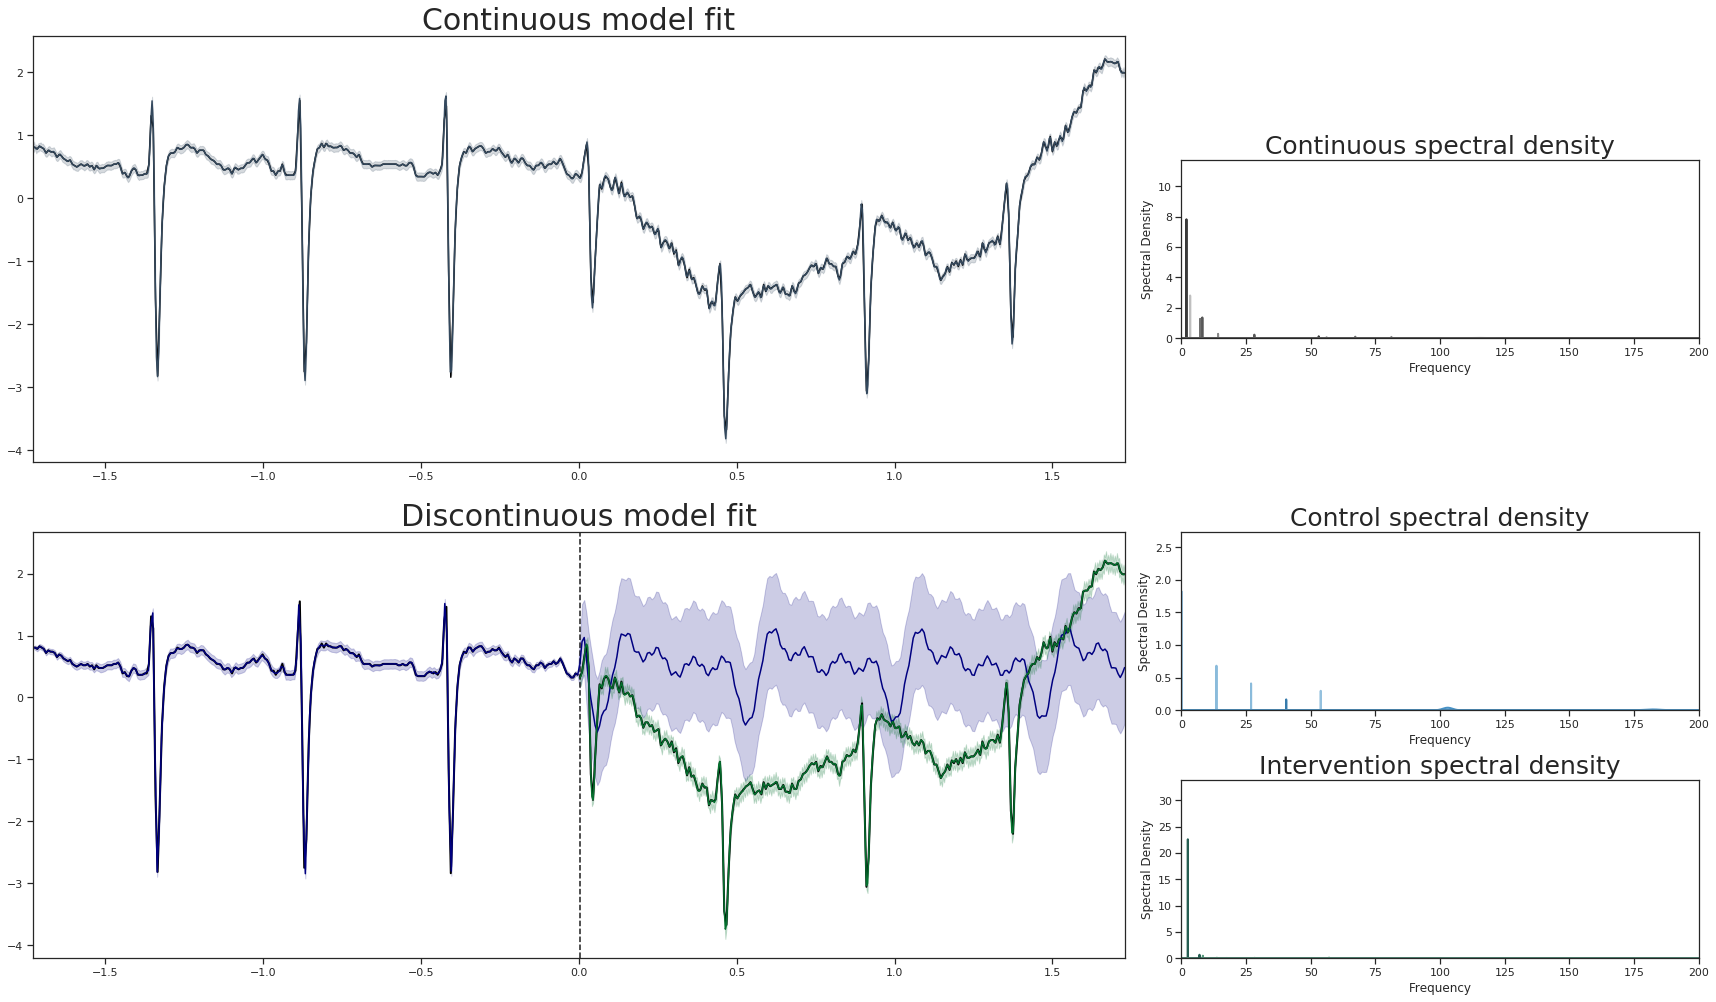

Log bayes factor:  -191.3751370961507


In [10]:
# Model initialization & parameters
max_freq        = nyquist * 3
max_length      = 15.
Q               = 25 #t.find_optimal_Q(x, y, min_Q=1, max_Q=30, max_length=max_length, max_freq=max_freq, plot_BIC_scores=True)
sm              = SpectralMixture(Q, max_length=max_length, max_freq=max_freq)                
#set_sm_priors(sm)    

dummy_kernel    = Linear()
a               = analyses.SimpleAnalysis([(x1, y1), (x2, y2)], dummy_kernel, b, share_params=False)
#const1, const2 = Constant(), Constant()
sm_continuous   = SpectralMixture(Q, x=X,y=Y,fs=40) + Constant()
sm_control      = SpectralMixture(Q, x=x1, y=y1, fs=40) + Constant()
sm_intervention = SpectralMixture(Q, x=x2, y=y2, fs=40) + Constant()

a.continuous_model.models[0].kernel    = sm_continuous
a.discontinuous_model.models[0].kernel = sm_control
a.discontinuous_model.models[1].kernel = sm_intervention


a.train(verbose=True)

log_bayes_factor = a.log_bayes_factor(verbose=True)
t.plot_posterior_model_spectrum(a, Q, padding=padding, max_x = 50,lineplot=True, scalar = 1.)
plt.savefig('veryearlyECGresult.pdf', dpi=250)
plt.show()
print('Log bayes factor: ', log_bayes_factor.numpy())

In [ ]:
# t.plot_posterior_model_spectrum(a, Q, padding=padding, max_x = 500,lineplot=False, scalar = 1.)
# plt.show()